# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

In [57]:
!wget "https://github.com/aporporato/ap-opencv-course-3-project-2/blob/main/trainer.zip?raw=true" -O trainer.zip


import zipfile

with zipfile.ZipFile("./trainer.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
!rm trainer.zip

--2022-01-02 15:57:43--  https://github.com/aporporato/ap-opencv-course-3-project-2/blob/main/trainer.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/aporporato/ap-opencv-course-3-project-2/raw/main/trainer.zip [following]
--2022-01-02 15:57:44--  https://github.com/aporporato/ap-opencv-course-3-project-2/raw/main/trainer.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/aporporato/ap-opencv-course-3-project-2/main/trainer.zip [following]
--2022-01-02 15:57:44--  https://raw.githubusercontent.com/aporporato/ap-opencv-course-3-project-2/main/trainer.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconte

In [58]:
%matplotlib inline

In [59]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [60]:
import os
import time
import glob
import random

from typing import Iterable
from dataclasses import dataclass

from PIL import Image

import numpy as np
from operator import itemgetter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import functional as FF

from torchvision import datasets, transforms, models

from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import MultiStepLR, ReduceLROnPlateau

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from trainer.trainer import Trainer
from trainer.trainer_with_early_stopping import TrainerWithEarlyStopping
import trainer.hooks as hooks
import trainer.configuration as configuration
from trainer.utils import setup_system, patch_configs
from trainer.metrics import AccuracyEstimator
from trainer.tensorboard_visualizer import TensorBoardVisualizer

from sklearn.metrics import accuracy_score

In [61]:
%load_ext tensorboard

%tensorboard --logdir=logs_ap_project_2

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [62]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
num_classes = 13

data_root = '/kaggle/input/opencv-pytorch-dl-course-classification'

## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods, which will be used to get training and validation data loader.

You need to write a custom dataset class to load data.

**Note; There is   no separate validation data. , You will thus have to create your own validation set, by dividing the train data into train and validation data. Usually, we do 80:20 ratio for train and validation, respectively.**


For example:

```python
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [64]:
class KenyanFood13Dataset(Dataset):
    """
    Kenyan Food Dataset, from Kaggle, for the Project 2 of Deep Learning with Pytorch (by OpenCV.org)
    """
    
    def __init__(self, data_root, train=True, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         train (boolean): True for training dataset and False for test dataset.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             It is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transforms it.
         
        """
        
        label_csv_path = os.path.join(data_root, 'train.csv')
        
        # load the data
        self.dataset = pd.read_csv(label_csv_path, delimiter=' *, *', engine='python')
        df_grouped = self.dataset.groupby('class')['id'].apply(list).to_dict()
        self.classes = list(df_grouped.keys())
        self.idx2class = {i: c for i, c in enumerate(self.classes)}
        self.class2idx = {c: i for i, c in enumerate(self.classes)}
        
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
        else:
            self.image_shape = None
            
        # set transform attribute
        self.transform = transform
                
        self.num_classes = num_classes
        
        # initialize the data dictionary
        self.data_dict = {
            'image_path': [],
            'label': []
        }
        
        num_split = 0.9
        cum_sum = 0
        self.ex_classes = {}
        path = os.path.join(data_root, 'images', 'images')
        for label, values in df_grouped.items():
            lim = int(len(values) * num_split)
            self.ex_classes[label] = cum_sum
            rang = range(lim) if train else range(lim, len(values))
            for i in rang:
                v = values[i]
                img_path = os.path.join(path, '{}.jpg'.format(v))
                self.data_dict['image_path'].append(img_path)
                self.data_dict['label'].append(label)
            cum_sum += len(rang)
                    
                
    def __len__(self):
        """
        Return length of the dataset
        """
        
        return len(self.data_dict['label'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][int(idx)]).convert("RGB")
        
        if self.image_shape is not None:
            image = FF.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
            
        target = self.class2idx[self.data_dict['label'][int(idx)]]
        
        return image, target
    
    
    def get_class_samples(self):
        """
        Return a sample iamge for each class.
        """
        
        r = []
        for l, i in self.ex_classes.items():
            r.append((l, Image.open(self.data_dict['image_path'][i]).convert("RGB")))
        return r

In [65]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
        ])
    
    return preprocess

In [66]:
def image_common_transforms(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

In [67]:
def data_augmentation_preprocess(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=0.5, a=0.5):
    preprocess = image_preprocess_transforms()
    
    augmentation_transforms = transforms.Compose([
        preprocess,
        # There are three groups of possible transformation, and two sub group for each of them:
        #  - Orientation
        #    - Horizontal Flop
        #    - Random Affine
        #  - Color
        #    - Jitter
        #    - Grayscale
        #  - Erasure
        #    - Random Crop
        #    - Random Pad
        #    - Random Erasing
        #    - Gaussian Blur
        # Each time every group is selected in random order, and then one of its subgroups at random is.
        #  Then there is some probability (controlled by p) that those subgroup is applied;
        #  If relevant, the amount of modification applied is controlled by a
        transforms.RandomOrder([
            # Orientation and Affine Augmentation
            transforms.RandomChoice([
                transforms.RandomHorizontalFlip(p),
                transforms.RandomChoice([
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=None, scale=None, shear=a)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=None, scale=(1-a/4, 1+a/2), shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=None, scale=(1-a/8, 1+a/4), shear=a/2)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=(a/4, a/4), scale=None, shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=(a/8, a/8), scale=None, shear=a/2)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=(a/8, a/8), scale=(1-a/8, 1+a/4), shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(0, translate=(a/16, a/16), scale=(1-a/16, 1+a/8), shear=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*200, translate=None, scale=None, shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*100, translate=None, scale=None, shear=a/2)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*100, translate=None, scale=(1-a/8, 1+a/4), shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*50, translate=None, scale=(1-a/16, 1+a/8), shear=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*100, translate=(a/8, a/8), scale=None, shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*50, translate=(a/16, a/16), scale=None, shear=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*50, translate=(a/16, a/16), scale=(1-a/16, 1+a/8), shear=None)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.RandomAffine(a*25, translate=(a/32, a/32), scale=(1-a/32, 1+a/16), shear=a/8)]), p)
                ])
            ]),
            # Color Augmentation
            transforms.RandomChoice([
                transforms.RandomChoice([
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=a/2)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=0, saturation=a, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=0, saturation=a/2, hue=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=a, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=a/2, saturation=0, hue=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=a/2, saturation=a/2, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=a/4, saturation=a/4, hue=a/8)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a, contrast=0, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/2, contrast=0, saturation=0, hue=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/2, contrast=0, saturation=a/2, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/4, contrast=0, saturation=a/4, hue=a/8)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/2, contrast=a/2, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/4, contrast=a/4, saturation=0, hue=a/8)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/4, contrast=a/4, saturation=a/4, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/8, contrast=a/8, saturation=a/8, hue=a/16)]), p)
                ]),
                transforms.RandomGrayscale(p)
            ]),
            # Erasure Augmentation
            transforms.RandomChoice([
                transforms.RandomApply(nn.ModuleList([transforms.RandomCrop(224, pad_if_needed=True, fill=mean)]), p),
                transforms.RandomApply(nn.ModuleList([transforms.Pad(int(a * 23) + 1), transforms.Resize(224)]), p),
                transforms.RandomErasing(p, value=list(mean)),
                transforms.RandomApply(nn.ModuleList([transforms.GaussianBlur(3)]), p)
            ]),
        ]),
        transforms.Normalize(mean, std)
    ])
    
    return augmentation_transforms

In [68]:
def resnet_data_augmentation_preprocess(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=0.5, a=0.5):
    preprocess = image_preprocess_transforms()
    
    augmentation_transforms = transforms.Compose([
        transforms.Resize(random.randint(256, 480)),
        transforms.RandomHorizontalFlip(p),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.RandomChoice([
                transforms.RandomChoice([
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=0, saturation=a, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=a, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=0, contrast=a/2, saturation=a/2, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a, contrast=0, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/2, contrast=0, saturation=0, hue=a/4)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/2, contrast=0, saturation=a/2, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/2, contrast=a/2, saturation=0, hue=0)]), p),
                    transforms.RandomApply(nn.ModuleList([transforms.ColorJitter(brightness=a/4, contrast=a/4, saturation=a/4, hue=0)]), p)
                ]),
                transforms.RandomGrayscale(p)
            ]),
        transforms.Normalize(mean, std)
    ])
    
    return augmentation_transforms

In [69]:
def get_resnet_mean_std():
    
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    
    return mean, std

In [70]:
def data_loader(data_root, train=True, transform=None, batch_size=16, shuffle=False, num_workers=2):
    dataset = KenyanFood13Dataset(data_root, train=train, image_shape=None, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [71]:
def get_data(batch_size, data_root, num_workers=2, data_augmentation=True):
    
    mean, std = get_resnet_mean_std()
    
    common_transforms = image_common_transforms(mean, std)
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        # train_transforms = data_augmentation_preprocess(mean, std)
        train_transforms = resnet_data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
    # train dataloader
    train_loader = data_loader(data_root,
                               train=True, 
                               transform=train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    test_loader = data_loader(data_root,
                              train=False, 
                              transform=common_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

### <font style="color:green">1.1 Data and Training Pipeline Check</font>

#### <font style="color:green">1.1.1 Data Exploration</font>

In [72]:
train_data = KenyanFood13Dataset(data_root, train=True)
validation_data = KenyanFood13Dataset(data_root, train=False)

In [73]:
idx2class = train_data.idx2class
class2idx = train_data.class2idx

Classes:

In [74]:
print(train_data.classes)
print(validation_data.classes)
print(idx2class)
print(class2idx)

['bhaji', 'chapati', 'githeri', 'kachumbari', 'kukuchoma', 'mandazi', 'masalachips', 'matoke', 'mukimo', 'nyamachoma', 'pilau', 'sukumawiki', 'ugali']
['bhaji', 'chapati', 'githeri', 'kachumbari', 'kukuchoma', 'mandazi', 'masalachips', 'matoke', 'mukimo', 'nyamachoma', 'pilau', 'sukumawiki', 'ugali']
{0: 'bhaji', 1: 'chapati', 2: 'githeri', 3: 'kachumbari', 4: 'kukuchoma', 5: 'mandazi', 6: 'masalachips', 7: 'matoke', 8: 'mukimo', 9: 'nyamachoma', 10: 'pilau', 11: 'sukumawiki', 12: 'ugali'}
{'bhaji': 0, 'chapati': 1, 'githeri': 2, 'kachumbari': 3, 'kukuchoma': 4, 'mandazi': 5, 'masalachips': 6, 'matoke': 7, 'mukimo': 8, 'nyamachoma': 9, 'pilau': 10, 'sukumawiki': 11, 'ugali': 12}


Number of samples:

In [75]:
print("Trainig Data:", len(train_data))
print("Validation Data:", len(validation_data))
print("Total:", len(train_data) + len(validation_data))

Trainig Data: 5876
Validation Data: 660
Total: 6536


Show examples:

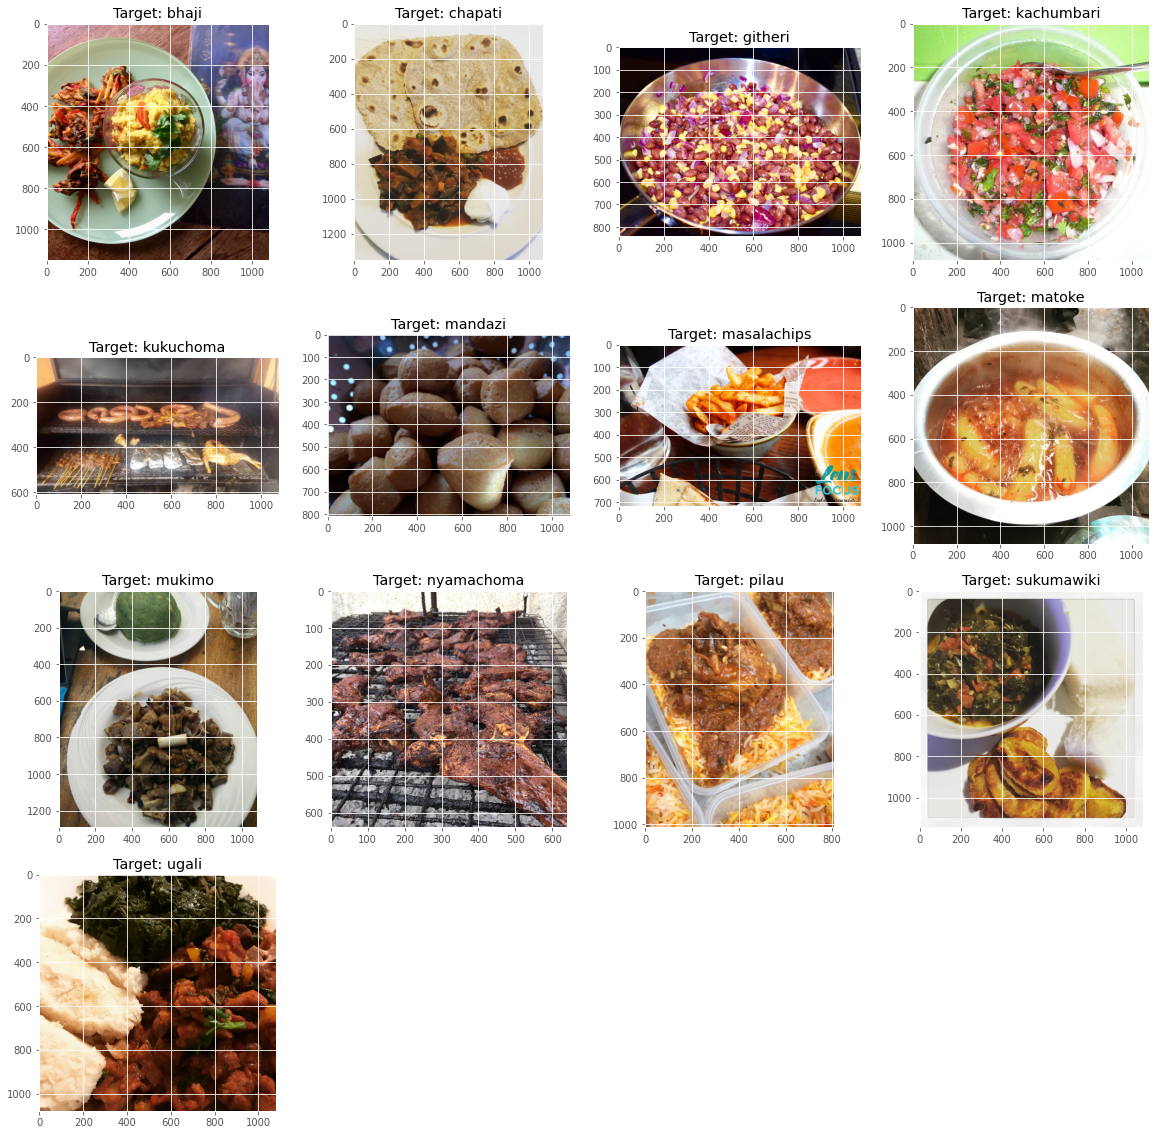

In [76]:
plt.figure(figsize=(20, 20))
for i, (label, img) in enumerate(train_data.get_class_samples()):
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.gca().set_title('Target: {0}'.format(label))
plt.show()

The remaining cells in the 1.1 subsection are disabled for performance purposes.\
Theese check are set in place for testing the pipeline with a simple model to ensure that it contains no trivial error: they heve been successufully executed once, and that's enough.\
Some results of the check model (shunk version of AlexNet with roughfly half the parameters, which architecture is reported below) on a small (0.5%) of the dataset can be seen in the `check_sample_predictions.png` and `check_wrong_prediction.png` images.\
If for some reason theese check have to be repeated, comment out the magic command `%%script false --no-raise-error` form the following cells.

#### <font style="color:green">1.1.2 Check Data Preparation</font>
Geneare a small dataset for pipline checking purposes.

In [77]:
%%script false --no-raise-error

subset_size = .5

In [78]:
%%script false --no-raise-error

def get_mean_std(data_root, num_workers=1, verbose=False):
    
    transform = image_preprocess_transforms()
    
    loader = data_loader(data_root, train=True, transform=transform, batch_size=16, shuffle=False, num_workers=num_workers)

    mean = 0.
    std = 0.
    
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    
    if verbose:
        print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

In [79]:
%%script false --no-raise-error

def subset_data_loader(data_root, train=True, transform=None, batch_size=16, shuffle=False, num_workers=1):
    dataset = KenyanFood13Dataset(data_root, train=train, image_shape=256, transform=transform)
    
    data_subset = torch.utils.data.Subset(dataset, np.arange(0, len(dataset), 1./subset_size))
    
    loader = torch.utils.data.DataLoader(data_subset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [80]:
%%script false --no-raise-error

def get_check_data(batch_size, data_root=data_root, num_workers=1):
    
    # mean, std = get_mean_std(data_root, verbose=True)
    mean, std = ([0.5778, 0.4629, 0.3459], [0.2380, 0.2463, 0.2467])
    
    show_transforms = image_preprocess_transforms()
    train_transforms = data_augmentation_preprocess(mean, std)
    test_transforms = image_common_transforms(mean, std)

    # show dataloader
    show_loader = subset_data_loader(data_root,
                                      train=True, 
                                      transform=show_transforms, 
                                      batch_size=batch_size, 
                                      shuffle=True, 
                                      num_workers=num_workers)

    # train dataloader
    train_loader = subset_data_loader(data_root,
                                      train=True, 
                                      transform=train_transforms, 
                                      batch_size=batch_size, 
                                      shuffle=True, 
                                      num_workers=num_workers)
    
    # test dataloader
    test_loader = subset_data_loader(data_root,
                                     train=False, 
                                     transform=test_transforms, 
                                     batch_size=batch_size, 
                                     # shuffle=False, 
                                     shuffle=True, 
                                     num_workers=num_workers)
    
    return show_loader, train_loader, test_loader

Check data before they pass through the model (to avoid normalization issues, use the validation set).

In [81]:
%%script false --no-raise-error

show_subset, train_subset, validation_subset = get_check_data(16)

In [82]:
%%script false --no-raise-error

plt.figure(figsize=(20, 20))
for images, labels in show_subset:
    for i in range(len(labels)):
        plt.subplot(4, 4, i+1)
        img = transforms.functional.to_pil_image(images[i])
        plt.imshow(img)
        plt.gca().set_title('Target: {0}'.format(labels[i]))
    plt.show()
    break

#### <font style="color:green">1.1.3 Check Configurations</font>

In [83]:
%%script false --no-raise-error

check_system_config = configuration.SystemConfig(seed=41,
                                                 cudnn_benchmark_enabled=True,
                                                 cudnn_deterministic=True)

In [84]:
%%script false --no-raise-error

mean, std = ([0.5778, 0.4629, 0.3459], [0.2380, 0.2463, 0.2467])
train_transforms = image_common_transforms(mean, std)
validation_transforms = image_common_transforms(mean, std)
check_dataset_config = configuration.DatasetConfig(root_dir=data_root,
                                                   train_transforms=train_transforms,
                                                   test_transforms=validation_transforms)

In [85]:
%%script false --no-raise-error

check_dataloader_config = configuration.DataloaderConfig(batch_size=32 if torch.cuda.is_available() else 16,
                                                         num_workers=1)

In [86]:
%%script false --no-raise-error

check_optimizer_config = configuration.OptimizerConfig(learning_rate=0.001,
                                                       momentum=0.9,
                                                       betas=(0.99, 0.999),
                                                       weight_decay=0.0001,
                                                       # lr_step_milestones=(30, 40),
                                                       lr_step_milestones=(6, 8),
                                                       lr_gamma=0.1,
                                                       # lr_scheduler_patience=15,
                                                       lr_scheduler_patience=2,
                                                       lr_scheduler_threshold=0.05)

In [87]:
%%script false --no-raise-error

check_trainer_config = configuration.TrainerConfig(model_dir="check_checkpoints",
                                                   model_saving_frequency=2,
                                                   device="cuda" if torch.cuda.is_available() else "cpu",
                                                   # epoch_num=50,
                                                   epoch_num=10,
                                                   progress_bar=False)

#### <font style="color:green">1.1.4 Check Model Training and Validation</font>

##### <font style="color:green">1.1.4.1 Check Model</font>
Shrunk version of AlexNet selected as model for pipeline checking

In [88]:
%%script false --no-raise-error

class ShrunkAlexNet(nn.Module):
    def __init__(self, num_classes: int=1000, dropout: float=0.5) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(32, 96, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(192, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.AdaptiveAvgPool2d((6, 6)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout),
            
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=dropout),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            
            nn.Linear(2048, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


##### <font style="color:green">1.1.4.2 Initial Check</font>

Check if the intial loss is around `log(num_classes)` and the initial accuracy is around `1/num_classes`.

In [89]:
%%script false --no-raise-error

class CheckInitLossAndAccuracy():
    def __init__(self, net, x, num_classes, target=None):
        self.net = net
        self.x = x
        self.num_classes = num_classes
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = self.x.size()[0]
        if target is None:
            self.target = torch.randint(0, self.num_classes, size=(self.batch_size,))
        else:
            self.target = target
        self.logits = self.net(self.x)

    def verify_init_loss(self):
        loss = self.criterion(self.logits, self.target)
        print("Expected loss is ", np.log(self.num_classes))
        print("Inferred loss is ", loss.item())
        return None

    def verify_init_accuracy(self):
        predictions = torch.argmax(F.softmax(self.logits, dim=1), axis=1)
        accuracy = accuracy_score(self.target, predictions.detach())
        print("Expected accuracy is ", 1 / self.num_classes)
        print("Inferred accuracy is ", accuracy)
        return None

In [90]:
%%script false --no-raise-error

x, target = next(iter(train_subset))

model = ShrunkAlexNet(num_classes)
check = CheckInitLossAndAccuracy(model, x, num_classes, target)
check.verify_init_loss()
check.verify_init_accuracy()

Check if loss decreases every epoch.

In [91]:
%%script false --no-raise-error

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001, momentum=0.9)

loss_list = []
num_epochs = 10
for epoch in range(num_epochs): 
    per_epoch_loss = 0
    for i, data in enumerate(validation_subset): 
        optimizer.zero_grad()
        x, target = data
        logits = model(x)
        loss = criterion(logits, target)
        temp_loss = loss.item()
        per_epoch_loss+=temp_loss
        loss.backward()
        optimizer.step()
        
    per_epoch_avg_loss = per_epoch_loss/(i+1)
    loss_list.append(per_epoch_avg_loss)
    print("Loss at epoch {0} = {1}".format(epoch + 1, per_epoch_avg_loss))

In [92]:
%%script false --no-raise-error

plt.figure(figsize=(6,4))
plt.plot(loss_list)
plt.title('Check Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,10))
plt.show()

Forward the same batch for multiple interations and check if loss drops down to 0

In [93]:
%%script false --no-raise-error

model_overfit = ShrunkAlexNet(num_classes)
optimizer = optim.Adam(model_overfit.parameters(), lr=0.001)

x, target = next(iter(validation_subset))

loss_list = []
num_iters = 10
for i in range(num_iters): 
    optimizer.zero_grad()
    logits = model_overfit(x)
    loss = criterion(logits, target)
    temp_loss = loss.item()
    loss.backward()
    optimizer.step()
    loss_list.append(temp_loss)
    print("Loss at iteration-{} is {}".format(i+1,temp_loss))

In [94]:
%%script false --no-raise-error

plt.figure(figsize = (6,4))
plt.plot(loss_list)
plt.title('Check Model Overfitting Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,i+1))
plt.show()

Forward-pass a zero input and check if loss is high.

In [95]:
%%script false --no-raise-error

criterion = nn.CrossEntropyLoss()

x = torch.zeros(size=(16, 3, 224, 224))
target = torch.randint(0, num_classes, size=(16,))
logits = model(x)

loss = criterion(logits,target)
print("Loss with zero-valued input is", loss.item())

##### <font style="color:green">1.1.4.3 Check Experiment</font>

In [96]:
%%script false --no-raise-error

class CheckExperiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = configuration.SystemConfig(),
        dataset_config: configuration.DatasetConfig = configuration.DatasetConfig(),
        dataloader_config: configuration.DataloaderConfig = configuration.DataloaderConfig(),
        optimizer_config: configuration.OptimizerConfig = configuration.OptimizerConfig()
    ):
        _, self.loader_train, self.loader_test = get_check_data(
            batch_size=dataloader_config.batch_size,
            data_root=dataset_config.root_dir,
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = ShrunkAlexNet(num_classes)
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        # self.optimizer = optim.RAdam(
        self.optimizer = optim.Adam(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            betas=optimizer_config.betas
        )
        self.lr_scheduler = ReduceLROnPlateau(
            self.optimizer,
            patience=optimizer_config.lr_scheduler_patience,
            threshold=optimizer_config.lr_scheduler_threshold,
            cooldown=optimizer_config.lr_scheduler_patience
        )
        self.visualizer = None

    def run(self, trainer_config: configuration.TrainerConfig) -> dict:

        device = torch.device(trainer_config.device)
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = TrainerWithEarlyStopping(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        model_trainer.register_hook("early_stop", hooks.early_stop_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics

Run the check experiment

In [97]:
%%script false --no-raise-error

check_experiment = CheckExperiment(system_config=check_system_config,
                                   dataset_config=check_dataset_config,
                                   dataloader_config=check_dataloader_config,
                                   optimizer_config=check_optimizer_config)
check_metrics = check_experiment.run(check_trainer_config)

#### <font style="color:green">1.1.5 Check Trained Model</font>

In [98]:
%%script false --no-raise-error

def load_model(model, model_dir=check_trainer_config.model_dir):
    list_of_files = glob.glob('{}/*'.format(model_dir))
    latest_model_file = max(list_of_files, key=os.path.getctime)
    
    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(latest_model_file))
    
    return model

In [99]:
%%script false --no-raise-error

check_model = load_model(ShrunkAlexNet(num_classes))

In [100]:
%%script false --no-raise-error

check_metrics

In [101]:
%%script false --no-raise-error

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(check_metrics["test_loss"])
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('epoch')
fig.suptitle('Check Results', fontsize=12)

axs[1].plot(check_metrics["train_loss"])
axs[1].set_title('Train Loss')
axs[1].set_xlabel('epoch')

axs[2].plot([metric['top1'] for metric in check_metrics["test_metric"]])
axs[2].set_title('Accuracy')
axs[2].set_xlabel('epoch')

plt.show()

#### <font style="color:green">1.1.6 Check Trained Model Prediction</font>

In [102]:
%%script false --no-raise-error

def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

In [103]:
%%script false --no-raise-error

def get_sample_prediction(model, data_root, mean, std):
    batch_size = 15
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 1
        
    
    # transformed data
    test_dataset_trans = KenyanFood13Dataset(data_root=data_root, train=False, transform=image_common_transforms(mean, std))
    # original image dataset
    test_dataset = KenyanFood13Dataset(data_root=data_root, train=False, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        index = i * interval
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
        
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (20, 15)
    fig = plt.figure()
    
    
    for i, target in enumerate(targets):
        plt.subplot(3, 5, i+1)
        img = transforms.functional.to_pil_image(imgs[i])
        plt.imshow(img)
        plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
    fig.savefig('check_sample_prediction.png')
    plt.show()
    
    return

In [104]:
%%script false --no-raise-error

get_sample_prediction(check_model, data_root, mean, std)

In [105]:
%%script false --no-raise-error

def get_wrong_prediction(model, data_root, mean, std):
    # Sample twice the images of the previous function...
    batch_size = 32
    device = "cuda" if torch.cuda.is_available() else "cpu"
    num_workers = 1
        
    
    # transformed data
    test_dataset_trans = KenyanFood13Dataset(data_root=data_root, train=False, transform=image_common_transforms(mean, std))
    # original image dataset
    test_dataset = KenyanFood13Dataset(data_root=data_root, train=False, transform=image_preprocess_transforms())
    
    data_len = test_dataset.__len__()
    
    interval = int(data_len/batch_size)
    
    imgs = []
    inputs = []
    targets = []
    for i in range(batch_size):
        # ... adjusting the index for the right amount of misclassified examples,...
        index = i * interval + 3
        trans_input, target = test_dataset_trans.__getitem__(index)
        img, _ = test_dataset.__getitem__(index)
        imgs.append(img)
        inputs.append(trans_input)
        targets.append(target)
        
    inputs = torch.stack(inputs)
    
    cls, prob = prediction(model, device, batch_input=inputs)
    
    plt.style.use('default')
    plt.rcParams["figure.figsize"] = (20, 15)
    fig = plt.figure()
    
    i = 0
    j = 0
    while i < len(targets) and j < 15:
        # ... and then print only the misclassified ones
        if test_dataset.classes[cls[i]] != test_dataset.classes[targets[i]]:
            j += 1
            plt.subplot(3, 5, j)
            img = transforms.functional.to_pil_image(imgs[i])
            plt.imshow(img)
            plt.gca().set_title('P:{0}({1:.2}), T:{2}'.format(test_dataset.classes[cls[i]], 
                                                     prob[i], 
                                                     test_dataset.classes[targets[i]]))
        i = i + 1
            
    fig.savefig('check_wrong_prediction.png')
    plt.show()
    
    return

In [106]:
%%script false --no-raise-error

get_wrong_prediction(check_model, data_root, mean, std)

In [107]:
%%capture
# Free memory and reset values
%xdel train_data
%xdel validation_data
%xdel subset_size
%xdel show_subset
%xdel train_subset
%xdel validation_subset
%xdel check_system_config
%xdel mean
%xdel std
%xdel train_transforms
%xdel validation_transforms
%xdel check_dataset_config
%xdel check_dataloader_config
%xdel check_optimizer_config
%xdel check_trainer_config
%xdel x
%xdel target
%xdel criterion
%xdel optimizer
%xdel loss_list
%xdel num_epochs
%xdel per_epoch_loss
%xdel model_overfit
%xdel check_experiment
%xdel check_metrics
%xdel check_model

## <font style="color:green">2. Configuration [5 Points]</font>

**Define your configuration here.**

For example:


```python
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

Already defined in the `trainer` package. For reference:

```python
@dataclass
class SystemConfig:
    seed: int = 41  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

@dataclass
class DatasetConfig:
    root_dir: str = "data"  # dataset directory root
    train_transforms: Iterable[Callable] = (
        ToTensor(),
    )  # data transformation to use during training data preparation
    test_transforms: Iterable[Callable] = (
        ToTensor(),
    )  # data transformation to use during test data preparation

@dataclass
class DataloaderConfig:
    batch_size: int = 256  # amount of data to pass through the network at each forward-backward iteration
    num_workers: int = 2  # number of concurrent processes using to prepare data

@dataclass
class OptimizerConfig:
    learning_rate: float = 0.001  # determines the speed of network's weights update
    momentum: float = 0.9  # used to improve vanilla SGD algorithm and provide better handling of local minimas
    betas: (float, float) = (0.9, 0.999)  # to use for Adam in presence of Dropout
    weight_decay: float = 0.0001  # amount of additional regularization on the weights values
    lr_step_milestones: Iterable = (
        30, 40
    )  # at which epochs should we make a "step" in learning rate (i.e. decrease it in some manner)
    lr_gamma: float = 0.1  # multiplier applied to current learning rate at each of lr_step_milestones
    lr_scheduler_patience: int = 10  # patience for some schedulers (i.e. ReduceLROnPlateau); also usable as cooldown
    lr_scheduler_threshold: float = 0.0001  # loss threshold for some schedulers (i.e. ReduceLROnPlateau)

@dataclass
class TrainerConfig:
    model_dir: str = "checkpoints"  # directory to save model states
    model_saving_frequency: int = 1  # frequency of model state savings per epochs
    device: str = "cpu"  # device to use for training.
    epoch_num: int = 50  # number of times the whole dataset will be passed through the network
    progress_bar: bool = True  # enable progress bar visualization during train process
```

Some of theese configuration will be overridden later.

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

**Define methods or classes that will be used in model evaluation. For example, accuracy, f1-score etc.**

Accuracy, train loss and test loss are included in the `trainer` package.

## <font style="color:green">4. Train and Validation [5 Points]</font>


**Write the methods or classes to be used for training and validation.**

The train and validate loop are included in the `trainer` package.

## <font style="color:green">5. Model [5 Points]</font>

**Define your model in this section.**

**You are allowed to use any pre-trained model.**

In [108]:
def pretrained_resnet(num_class=num_classes, freeze_first : int=4):
    resnet = models.resnet18(pretrained=True)
    
    # Trainable layer names
    trainable_layer_names = ["conv1", "bn1", "layer1", "layer2", "layer3", "layer4"]
    freeze_first = 2 if freeze_first == 1 else min(max(0, freeze_first), len(trainable_layer_names))
    for layer_name in trainable_layer_names[:freeze_first]:
        for param in getattr(resnet, layer_name).parameters():
            param.requires_grad = False
            
    last_layer_in = resnet.fc.in_features
    resnet.fc = nn.Linear(last_layer_in, num_class, bias=False)  # requires_grad = True
    
    return resnet

In [109]:
resnet_finetune = pretrained_resnet() # range (0, 6), extremes included
# print({n: [(nn, p.requires_grad) for nn, p in l.named_parameters()] for n, l in resnet_finetune.named_children()})
print(resnet_finetune)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## <font style="color:green">6. Utils [5 Points]</font>

**Define those methods or classes, which have  not been covered in the above sections.**

In [110]:
def prediction(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy(), pred_prob.cpu().numpy()

## <font style="color:green">7. Experiment [5 Points]</font>

**Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.**

In [111]:
class Experiment:
    def __init__(
        self,
        system_config: configuration.SystemConfig = configuration.SystemConfig(),
        dataset_config: configuration.DatasetConfig = configuration.DatasetConfig(),
        dataloader_config: configuration.DataloaderConfig = configuration.DataloaderConfig(),
        optimizer_config: configuration.OptimizerConfig = configuration.OptimizerConfig()
    ):
        self.loader_train, self.loader_test = get_data(
            batch_size=dataloader_config.batch_size,
            data_root=dataset_config.root_dir,
            num_workers=dataloader_config.num_workers
        )
        
        setup_system(system_config)

        self.model = resnet_finetune
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric_fn = AccuracyEstimator(topk=(1, ))
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=optimizer_config.learning_rate,
            momentum=optimizer_config.momentum,
            weight_decay=optimizer_config.weight_decay
        )
        self.lr_scheduler = MultiStepLR(
            self.optimizer,
            milestones=optimizer_config.lr_step_milestones,
            gamma=optimizer_config.lr_gamma
        )
        self.visualizer = TensorBoardVisualizer()

    def run(self, trainer_config: configuration.TrainerConfig) -> dict:

        # device = torch.device(trainer_config.device)
        device = "cuda" if torch.cuda.is_available() else trainer_config.device
        self.model = self.model.to(device)
        self.loss_fn = self.loss_fn.to(device)

        model_trainer = Trainer(
            model=self.model,
            loader_train=self.loader_train,
            loader_test=self.loader_test,
            loss_fn=self.loss_fn,
            metric_fn=self.metric_fn,
            optimizer=self.optimizer,
            lr_scheduler=self.lr_scheduler,
            device=device,
            data_getter=itemgetter(0),
            target_getter=itemgetter(1),
            stage_progress=trainer_config.progress_bar,
            get_key_metric=itemgetter("top1"),
            visualizer=self.visualizer,
            model_saving_frequency=trainer_config.model_saving_frequency,
            save_dir=trainer_config.model_dir
        )

        model_trainer.register_hook("end_epoch", hooks.end_epoch_hook_classification)
        self.metrics = model_trainer.fit(trainer_config.epoch_num)
        return self.metrics, self.model

In [112]:
mean, std = get_resnet_mean_std()
# train_transfrom = data_augmentation_preprocess(mean, std)
train_transfrom = resnet_data_augmentation_preprocess(mean, std)
validation_transform = image_common_transforms(mean, std)
dataset_config = configuration.DatasetConfig(root_dir=data_root,
                                             train_transforms=train_transfrom,
                                             test_transforms=validation_transform)
dataloader_config, trainer_config = patch_configs(epoch_num_to_set=10,
                                                  batch_size_to_set=64 if torch.cuda.is_available() else 16)
optimizer_config = configuration.OptimizerConfig(learning_rate=1e-2,
                                                 lr_step_milestones=(1, 6))
experiment = Experiment(dataset_config=dataset_config,
                        dataloader_config=dataloader_config,
                        optimizer_config=optimizer_config)
metrics, model = experiment.run(trainer_config)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/92 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f55540b7cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f55540b7cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

  0%|          | 0/11 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f55540b7cb0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


  0%|          | 0/92 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(metrics["train_loss"])
axs[0].set_title('Train Loss')
axs[0].set_xlabel('epoch')
fig.suptitle('Experiments Results', fontsize=12)

axs[1].plot(metrics["test_loss"])
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('epoch')

axs[2].plot([metric['top1'] for metric in metrics["test_metric"]])
axs[2].set_title('Accuracy')
axs[2].set_xlabel('epoch')

plt.show()

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

**Share your TensorBoard scalars logs link here. You can also share (not mandatory) your GitHub link, if you have pushed this project in GitHub.**


For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

In [ ]:
%reload_ext tensorboard

In [ ]:
# %tensorboard dev upload --logdir logs_ap_project_2/ --name "Aureliano Porporato Project 2 Experiment" --description "Aureliano Porporato \"Deep Learning with Pytorch\" Project 2"

Tensorboard.dev logs for the project can be found [here]().\
The notebook has been uploaded to GitHub [here](https://github.com/aporporato/ap-opencv-course-3-project-2/blob/main/aureliano-porporato-project-2-notebook.ipynb).

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

**Share your Kaggle profile link  with us here to score points in  the competition.**

**For full points, you need a minimum accuracy of `75%` on the test data. If accuracy is less than `70%`, you gain  no points for this section.**


**Submit `submission.csv` (prediction for images in `test.csv`), in the `Submit Predictions` tab in Kaggle, to get evaluated for  this section.**

In [ ]:
class KenyanFood13Testset(Dataset):
    """
    Kenyan Food unlabel Testset, from Kaggle, for the Project 2 of Deep Learning with Pytorch (by OpenCV.org)
    """
    
    def __init__(self, data_root, idx2class, class2idx, image_shape=None, transform=None):
        
        """
        init method of the class.
        
         Parameters:
         
         data_root (string): path of root directory.
         
         image_shape (int or tuple or list): [optional] int or tuple or list. Defaut is None. 
                                             It is not None image will resize to the given shape.
                                 
         transform (method): method that will take PIL image and transforms it.
         
        """
        
        label_less_csv_path = os.path.join(data_root, 'test.csv')
        
        self.testset = pd.read_csv(label_less_csv_path)
        
        self.idx2class = idx2class
        self.class2idx = class2idx
        
        # set image_resize attribute
        if image_shape is not None:
            if isinstance(image_shape, int):
                self.image_shape = (image_shape, image_shape)
            
            elif isinstance(image_shape, tuple) or isinstance(image_shape, list):
                assert len(image_shape) == 1 or len(image_shape) == 2, 'Invalid image_shape tuple size'
                if len(image_shape) == 1:
                    self.image_shape = (image_shape[0], image_shape[0])
                else:
                    self.image_shape = image_shape
            else:
                raise NotImplementedError 
        else:
            self.image_shape = None
            
        # set transform attribute
        self.transform = transform
                
        self.num_classes = num_classes
        
        self.data_dict = {
            'image_path': [],
            'image_name': []
        }
        
        dir_path = os.path.join(data_root, 'images', 'images')

        for _, image in self.testset.iterrows():
            image_name = image[0]
            image_path = os.path.join(dir_path, '{}.jpg'.format(image_name))
            self.data_dict['image_path'].append(image_path)
            self.data_dict['image_name'].append(image_name)
            
    def get_test(self):
        return self.data_dict
                    
                
    def __len__(self):
        """
        Return length of the dataset
        """
        
        return len(self.data_dict['image_name'])
    
    
    def __getitem__(self, idx):
        """
        For given index, return images with resize and preprocessing.
        """
        
        image = Image.open(self.data_dict['image_path'][int(idx)]).convert("RGB")
        
        if self.image_shape is not None:
            image = FF.resize(image, self.image_shape)
            
        if self.transform is not None:
            image = self.transform(image)
        
        return image, self.num_classes
    
    
    def create_submission(self, predictions):
        """
        Prepare CSV file for submission.
        """
        labels = [self.idx2class[p] for p in predictions]
        submission_df = pd.DataFrame(list(zip(self.data_dict['image_name'], labels)), columns=['id', 'class'])
        submission_df.to_csv("./submission.csv", index=False)

In [ ]:
mean, std = get_resnet_mean_std()
test_transform = image_common_transforms(mean, std)
test_set = KenyanFood13Testset(data_root, idx2class, class2idx,
                               image_shape=None,
                               transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64 if torch.cuda.is_available() else 16,
                                          num_workers=2 if torch.cuda.is_available() else 1,
                                          shuffle=False)

In [ ]:
preds = np.array([])
for data, _ in test_loader:
    p, _ = prediction(model, "cuda" if torch.cuda.is_available() else "cpu", data)
    preds = np.concatenate((preds, p), axis=None)
    

test_set.create_submission(preds)
print("File created")